In [ ]:
from sklearn.metrics import classification_report,roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import helper_functions1 as hf

In [2]:
# load dataframe 
users_df = pd.read_pickle('cleaned_data/bikes_logistic.pkl')

In [3]:
# initialize the class

users = hf.UserLogReg(users_df,'above_avg_casual')

In [4]:
users_df.above_avg_casual.value_counts(normalize=True)


In [5]:
users_df.head(3)

### labels imbalances 
64% below and 36% above casual user

need do weighted sampling 

In [6]:
#Define appropriate X and y

y,X = users.target_features()
# Split the data into train and test sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)


In [7]:
display(y_train.value_counts(normalize = True))
display(y_test.value_counts(normalize=True))
# similar distribution for both 

0    0.637057
1    0.362943
Name: above_avg_casual, dtype: float64

0    0.651323
1    0.348677
Name: above_avg_casual, dtype: float64

In [9]:
# check for weights impact 
weights = [None, 'balanced', {1:0.36, 0:0.64}]
results = []
for weight in weights:
    results.append(users.logreg(weight,X_train,y_train,X_test,y_test))

In [10]:
# check for AUC 
for i in range(3):
    print(f'{weights[i]} weight yields auc {results[i][-1]}')

None weight yields auc 0.7810674176958332
balanced weight yields auc 0.8092674550140526
{1: 0.36, 0: 0.64} weight yields auc 0.7209770667879509


In [13]:
# initialize smote 
X_smote, y_smote = users.smote_oversampling(X_train,y_train)
print(pd.Series(y_smote).value_counts())#Preview synthetic sample class distribution
# try result 
smote_result = users.logreg(None, X_smote, y_smote,X_test,y_test)
print(f'smote oversampling yields auc {smote_result[-1]}')

1    8857
0    8857
dtype: int64
smote oversampling yields auc 0.8091340715343619


### sampling didn't seem to affect AUC very much 

In [14]:
best_model = users.grid_search_parameters(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 193 out of 200 | elapsed:   10.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished


In [15]:
best_model.best_params_

{'classifier': LogisticRegression(C=0.03359818286283781, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 0.03359818286283781,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

### best parameter is :
penalty: l2, solver is lbfgs
* change in class 

In [16]:
### fit the model with smote sampling 
final_model = users.logreg(None, X_smote,y_smote, X_test,y_test)

In [17]:
print (f'AUC for final model for test: {final_model[-1]}')

AUC for final model for test: 0.8091340715343619


In [18]:
y_pred = final_model[1]
# check for final report 
print(classification_report(y_test, y_pred))
print(f'balanced accuracy is {balanced_accuracy_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2264
           1       0.70      0.81      0.75      1212

    accuracy                           0.81      3476
   macro avg       0.79      0.81      0.80      3476
weighted avg       0.82      0.81      0.81      3476

balanced accuracy is 0.8091340715343619


In [19]:
users.confusion_table(y_test,y_pred)  # high false positive due to rare events 

,Pred_0,Pred_1
True_0,1835,429
True_1,233,979


0.8091340715343619

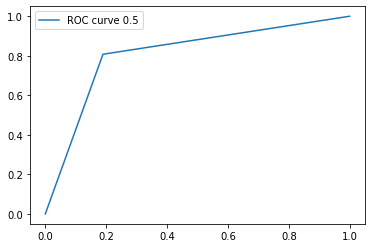

In [20]:
users.plot_auc_curve(y_test,y_pred)

In [21]:
# top 10 features 
users.coef_results(final_model,X)[0]

,features,coef
0,temp,2.140821
1,workingday_working,1.389162
2,hr_14,1.306845
3,hr_11,1.289160
4,hr_10,1.224593
5,hr_7,1.180471
6,hr_8,1.172824
7,hr_5,1.061214
8,hr_6,1.055808
9,hr_15,1.043975


In [22]:
# bottom 5 features
users.coef_results(final_model,X)[1]

,features,coef
0,weathersit_mist,0.128219
1,hr_16,0.124916
2,weekday_Mon,0.077585
3,hr_4,0.033490
4,weathersit_heavy_rain_snow,0.010198
